In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 pr9b3bpw


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pr9b3bpw:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.0


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                    | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                            | 1/2604 [00:00<25:50,  1.68it/s]

  0%|▏                                                                                                           | 5/2604 [00:00<04:46,  9.07it/s]

  0%|▍                                                                                                          | 10/2604 [00:00<02:29, 17.29it/s]

  1%|▌                                                                                                          | 15/2604 [00:00<01:47, 24.13it/s]

  1%|▊                                                                                                          | 20/2604 [00:01<01:27, 29.53it/s]

  1%|█                                                                                                          | 25/2604 [00:01<01:16, 33.71it/s]

  1%|█▏                                                                                                         | 30/2604 [00:01<01:10, 36.77it/s]

  1%|█▍                                                                                                         | 35/2604 [00:01<01:05, 39.02it/s]

  2%|█▋                                                                                                         | 40/2604 [00:01<01:03, 40.64it/s]

  2%|█▊                                                                                                         | 45/2604 [00:01<01:01, 41.90it/s]

  2%|██                                                                                                         | 50/2604 [00:01<00:59, 42.76it/s]

  2%|██▎                                                                                                        | 55/2604 [00:01<00:58, 43.30it/s]

  2%|██▍                                                                                                        | 60/2604 [00:01<00:58, 43.71it/s]

  2%|██▋                                                                                                        | 65/2604 [00:02<00:57, 43.98it/s]

  3%|██▉                                                                                                        | 70/2604 [00:02<00:57, 44.17it/s]

  3%|███                                                                                                        | 75/2604 [00:02<00:57, 44.28it/s]

  3%|███▎                                                                                                       | 80/2604 [00:02<00:56, 44.40it/s]

  3%|███▍                                                                                                       | 85/2604 [00:02<00:56, 44.43it/s]

  3%|███▋                                                                                                       | 90/2604 [00:02<00:56, 44.48it/s]

  4%|███▉                                                                                                       | 95/2604 [00:02<00:56, 44.54it/s]

  4%|████                                                                                                      | 100/2604 [00:02<00:56, 44.52it/s]

  4%|████▎                                                                                                     | 105/2604 [00:02<00:56, 44.53it/s]

  4%|████▍                                                                                                     | 110/2604 [00:03<00:56, 44.53it/s]

  4%|████▋                                                                                                     | 115/2604 [00:03<00:55, 44.52it/s]

  5%|████▉                                                                                                     | 120/2604 [00:03<00:55, 44.50it/s]

  5%|█████                                                                                                     | 125/2604 [00:03<00:55, 44.51it/s]

  5%|█████▎                                                                                                    | 130/2604 [00:03<00:55, 44.55it/s]

  5%|█████▍                                                                                                    | 135/2604 [00:03<00:55, 44.55it/s]

  5%|█████▋                                                                                                    | 140/2604 [00:03<00:55, 44.52it/s]

  6%|█████▉                                                                                                    | 145/2604 [00:03<00:55, 44.50it/s]

  6%|██████                                                                                                    | 150/2604 [00:03<00:55, 44.56it/s]

  6%|██████▎                                                                                                   | 155/2604 [00:04<00:54, 44.58it/s]

  6%|██████▌                                                                                                   | 160/2604 [00:04<00:54, 44.56it/s]

  6%|██████▋                                                                                                   | 165/2604 [00:04<00:54, 44.61it/s]

  7%|██████▉                                                                                                   | 170/2604 [00:04<00:54, 44.61it/s]

  7%|███████                                                                                                   | 175/2604 [00:04<00:54, 44.58it/s]

  7%|███████▎                                                                                                  | 180/2604 [00:04<00:54, 44.57it/s]

  7%|███████▌                                                                                                  | 185/2604 [00:04<00:54, 44.63it/s]

  7%|███████▋                                                                                                  | 190/2604 [00:04<00:54, 44.62it/s]

  7%|███████▉                                                                                                  | 195/2604 [00:04<00:53, 44.62it/s]

  8%|████████▏                                                                                                 | 200/2604 [00:05<00:53, 44.70it/s]

  8%|████████▎                                                                                                 | 205/2604 [00:05<00:53, 44.66it/s]

  8%|████████▌                                                                                                 | 210/2604 [00:05<00:53, 44.61it/s]

  8%|████████▊                                                                                                 | 215/2604 [00:05<00:53, 44.63it/s]

  8%|████████▉                                                                                                 | 220/2604 [00:05<00:53, 44.70it/s]

  9%|█████████▏                                                                                                | 225/2604 [00:05<00:53, 44.71it/s]

  9%|█████████▎                                                                                                | 230/2604 [00:05<00:53, 44.73it/s]

  9%|█████████▌                                                                                                | 235/2604 [00:05<00:52, 44.81it/s]

  9%|█████████▊                                                                                                | 240/2604 [00:05<00:52, 44.79it/s]

  9%|█████████▉                                                                                                | 245/2604 [00:06<00:52, 44.78it/s]

 10%|██████████▏                                                                                               | 250/2604 [00:06<00:52, 44.79it/s]

 10%|██████████▍                                                                                               | 255/2604 [00:06<00:52, 44.73it/s]

 10%|██████████▌                                                                                               | 260/2604 [00:06<00:52, 44.72it/s]

 10%|██████████▊                                                                                               | 265/2604 [00:06<00:52, 44.81it/s]

 10%|██████████▉                                                                                               | 270/2604 [00:06<00:52, 44.81it/s]

 11%|███████████▏                                                                                              | 275/2604 [00:06<00:51, 44.80it/s]

 11%|███████████▍                                                                                              | 280/2604 [00:06<00:51, 44.83it/s]

 11%|███████████▌                                                                                              | 285/2604 [00:06<00:51, 44.80it/s]

 11%|███████████▊                                                                                              | 290/2604 [00:07<00:51, 44.78it/s]

 11%|████████████                                                                                              | 295/2604 [00:07<00:51, 44.78it/s]

 12%|████████████▏                                                                                             | 300/2604 [00:07<00:51, 44.79it/s]

 12%|████████████▍                                                                                             | 305/2604 [00:07<00:51, 44.67it/s]

 12%|████████████▌                                                                                             | 310/2604 [00:07<00:51, 44.63it/s]

 12%|████████████▊                                                                                             | 315/2604 [00:07<00:51, 44.69it/s]

 12%|█████████████                                                                                             | 320/2604 [00:07<00:51, 44.64it/s]

 12%|█████████████▏                                                                                            | 325/2604 [00:07<00:51, 44.64it/s]

 13%|█████████████▍                                                                                            | 330/2604 [00:07<00:50, 44.62it/s]

 13%|█████████████▋                                                                                            | 335/2604 [00:08<00:50, 44.68it/s]

 13%|█████████████▊                                                                                            | 340/2604 [00:08<00:50, 44.63it/s]

 13%|██████████████                                                                                            | 345/2604 [00:08<00:50, 44.62it/s]

 13%|██████████████▏                                                                                           | 350/2604 [00:08<00:50, 44.61it/s]

 14%|██████████████▍                                                                                           | 355/2604 [00:08<00:50, 44.67it/s]

 14%|██████████████▋                                                                                           | 360/2604 [00:08<00:50, 44.64it/s]

 14%|██████████████▊                                                                                           | 365/2604 [00:08<00:50, 44.65it/s]

 14%|███████████████                                                                                           | 370/2604 [00:08<00:50, 44.66it/s]

 14%|███████████████▎                                                                                          | 375/2604 [00:08<00:49, 44.74it/s]

 15%|███████████████▍                                                                                          | 380/2604 [00:09<00:49, 44.68it/s]

 15%|███████████████▋                                                                                          | 385/2604 [00:09<00:49, 44.66it/s]

 15%|███████████████▉                                                                                          | 390/2604 [00:09<00:49, 44.73it/s]

 15%|████████████████                                                                                          | 395/2604 [00:09<00:49, 44.73it/s]

 15%|████████████████▎                                                                                         | 400/2604 [00:09<00:49, 44.75it/s]

 16%|████████████████▍                                                                                         | 405/2604 [00:09<00:49, 44.74it/s]

 16%|████████████████▋                                                                                         | 410/2604 [00:09<00:48, 44.83it/s]

 16%|████████████████▉                                                                                         | 415/2604 [00:09<00:48, 44.84it/s]

 16%|█████████████████                                                                                         | 420/2604 [00:09<00:48, 44.83it/s]

 16%|█████████████████▎                                                                                        | 425/2604 [00:10<00:48, 44.83it/s]

 17%|█████████████████▌                                                                                        | 430/2604 [00:10<00:48, 44.86it/s]

 17%|█████████████████▋                                                                                        | 435/2604 [00:10<00:48, 44.84it/s]

 17%|█████████████████▉                                                                                        | 440/2604 [00:10<00:48, 44.82it/s]

 17%|██████████████████                                                                                        | 445/2604 [00:10<00:48, 44.89it/s]

 17%|██████████████████▎                                                                                       | 450/2604 [00:10<00:48, 44.87it/s]

 17%|██████████████████▌                                                                                       | 455/2604 [00:10<00:48, 44.75it/s]

 18%|██████████████████▋                                                                                       | 460/2604 [00:10<00:47, 44.84it/s]

 18%|██████████████████▉                                                                                       | 465/2604 [00:10<00:47, 44.91it/s]

 18%|███████████████████▏                                                                                      | 470/2604 [00:11<00:47, 44.69it/s]

 18%|███████████████████▎                                                                                      | 475/2604 [00:11<00:47, 44.70it/s]

 18%|███████████████████▌                                                                                      | 480/2604 [00:11<00:47, 44.73it/s]

 19%|███████████████████▋                                                                                      | 485/2604 [00:11<00:47, 44.81it/s]

 19%|███████████████████▉                                                                                      | 490/2604 [00:11<00:47, 44.79it/s]

 19%|████████████████████▏                                                                                     | 495/2604 [00:11<00:47, 44.78it/s]

 19%|████████████████████▎                                                                                     | 500/2604 [00:11<00:46, 44.85it/s]

 19%|████████████████████▌                                                                                     | 505/2604 [00:11<00:46, 44.83it/s]

 20%|████████████████████▊                                                                                     | 510/2604 [00:11<00:46, 44.81it/s]

 20%|████████████████████▉                                                                                     | 515/2604 [00:12<00:46, 44.81it/s]

 20%|█████████████████████▏                                                                                    | 520/2604 [00:12<00:46, 44.82it/s]

 20%|█████████████████████▎                                                                                    | 525/2604 [00:12<00:46, 44.88it/s]

 20%|█████████████████████▌                                                                                    | 530/2604 [00:12<00:46, 44.86it/s]

 21%|█████████████████████▊                                                                                    | 535/2604 [00:12<00:46, 44.85it/s]

 21%|█████████████████████▉                                                                                    | 540/2604 [00:12<00:45, 44.91it/s]

 21%|██████████████████████▏                                                                                   | 545/2604 [00:12<00:45, 44.86it/s]

 21%|██████████████████████▍                                                                                   | 550/2604 [00:12<00:45, 44.78it/s]

 21%|██████████████████████▌                                                                                   | 555/2604 [00:13<00:45, 44.76it/s]

 22%|██████████████████████▊                                                                                   | 560/2604 [00:13<00:45, 44.80it/s]

 22%|██████████████████████▉                                                                                   | 565/2604 [00:13<00:45, 44.80it/s]

 22%|███████████████████████▏                                                                                  | 570/2604 [00:13<00:45, 44.80it/s]

 22%|███████████████████████▍                                                                                  | 575/2604 [00:13<00:45, 44.75it/s]

 22%|███████████████████████▌                                                                                  | 580/2604 [00:13<00:45, 44.76it/s]

 22%|███████████████████████▊                                                                                  | 585/2604 [00:13<00:45, 44.70it/s]

 23%|████████████████████████                                                                                  | 590/2604 [00:13<00:45, 44.72it/s]

 23%|████████████████████████▏                                                                                 | 595/2604 [00:13<00:44, 44.66it/s]

 23%|████████████████████████▍                                                                                 | 600/2604 [00:14<00:44, 44.71it/s]

 23%|████████████████████████▋                                                                                 | 605/2604 [00:14<00:44, 44.66it/s]

 23%|████████████████████████▊                                                                                 | 610/2604 [00:14<00:44, 44.65it/s]

 24%|█████████████████████████                                                                                 | 615/2604 [00:14<00:44, 44.70it/s]

 24%|█████████████████████████▏                                                                                | 620/2604 [00:14<00:44, 44.65it/s]

 24%|█████████████████████████▍                                                                                | 625/2604 [00:14<00:44, 44.66it/s]

 24%|█████████████████████████▋                                                                                | 630/2604 [00:14<00:44, 44.70it/s]

 24%|█████████████████████████▊                                                                                | 635/2604 [00:14<00:44, 44.73it/s]

 25%|██████████████████████████                                                                                | 640/2604 [00:14<00:43, 44.73it/s]

 25%|██████████████████████████▎                                                                               | 645/2604 [00:15<00:43, 44.70it/s]

 25%|██████████████████████████▍                                                                               | 650/2604 [00:15<00:43, 44.60it/s]

 25%|██████████████████████████▋                                                                               | 655/2604 [00:15<00:43, 44.69it/s]

 25%|██████████████████████████▊                                                                               | 660/2604 [00:15<00:43, 44.65it/s]

 26%|███████████████████████████                                                                               | 665/2604 [00:15<00:43, 44.62it/s]

 26%|███████████████████████████▎                                                                              | 670/2604 [00:15<00:43, 44.69it/s]

 26%|███████████████████████████▍                                                                              | 675/2604 [00:15<00:43, 44.66it/s]

 26%|███████████████████████████▋                                                                              | 680/2604 [00:15<00:43, 44.61it/s]

 26%|███████████████████████████▉                                                                              | 685/2604 [00:15<00:43, 44.58it/s]

 26%|████████████████████████████                                                                              | 690/2604 [00:16<00:42, 44.65it/s]

 27%|████████████████████████████▎                                                                             | 695/2604 [00:16<00:42, 44.62it/s]

 27%|████████████████████████████▍                                                                             | 700/2604 [00:16<00:42, 44.62it/s]

 27%|████████████████████████████▋                                                                             | 705/2604 [00:16<00:42, 44.66it/s]

 27%|████████████████████████████▉                                                                             | 710/2604 [00:16<00:42, 44.64it/s]

 27%|█████████████████████████████                                                                             | 715/2604 [00:16<00:42, 44.60it/s]

 28%|█████████████████████████████▎                                                                            | 720/2604 [00:16<00:42, 44.60it/s]

 28%|█████████████████████████████▌                                                                            | 725/2604 [00:16<00:42, 44.64it/s]

 28%|█████████████████████████████▋                                                                            | 730/2604 [00:16<00:42, 44.49it/s]

 28%|█████████████████████████████▉                                                                            | 735/2604 [00:17<00:41, 44.57it/s]

 28%|██████████████████████████████                                                                            | 740/2604 [00:17<00:41, 44.53it/s]

 29%|██████████████████████████████▎                                                                           | 745/2604 [00:17<00:41, 44.54it/s]

 29%|██████████████████████████████▌                                                                           | 750/2604 [00:17<00:41, 44.66it/s]

 29%|██████████████████████████████▋                                                                           | 755/2604 [00:17<00:41, 44.53it/s]

 29%|██████████████████████████████▉                                                                           | 760/2604 [00:17<00:41, 44.57it/s]

 29%|███████████████████████████████▏                                                                          | 765/2604 [00:17<00:41, 44.63it/s]

 30%|███████████████████████████████▎                                                                          | 770/2604 [00:17<00:41, 44.61it/s]

 30%|███████████████████████████████▌                                                                          | 775/2604 [00:17<00:41, 44.60it/s]

 30%|███████████████████████████████▊                                                                          | 780/2604 [00:18<00:40, 44.62it/s]

 30%|███████████████████████████████▉                                                                          | 785/2604 [00:18<00:40, 44.65it/s]

 30%|████████████████████████████████▏                                                                         | 790/2604 [00:18<00:40, 44.61it/s]

 31%|████████████████████████████████▎                                                                         | 795/2604 [00:18<00:40, 44.54it/s]

 31%|████████████████████████████████▌                                                                         | 800/2604 [00:18<00:40, 44.53it/s]

 31%|████████████████████████████████▊                                                                         | 805/2604 [00:18<00:40, 44.51it/s]

 31%|████████████████████████████████▉                                                                         | 810/2604 [00:18<00:40, 44.57it/s]

 31%|█████████████████████████████████▏                                                                        | 815/2604 [00:18<00:40, 44.55it/s]

 31%|█████████████████████████████████▍                                                                        | 820/2604 [00:18<00:40, 44.47it/s]

 32%|█████████████████████████████████▌                                                                        | 825/2604 [00:19<00:39, 44.49it/s]

 32%|█████████████████████████████████▊                                                                        | 830/2604 [00:19<00:39, 44.54it/s]

 32%|█████████████████████████████████▉                                                                        | 835/2604 [00:19<00:39, 44.47it/s]

 32%|██████████████████████████████████▏                                                                       | 840/2604 [00:19<00:39, 44.43it/s]

 32%|██████████████████████████████████▍                                                                       | 845/2604 [00:19<00:39, 44.42it/s]

 33%|██████████████████████████████████▌                                                                       | 850/2604 [00:19<00:39, 44.48it/s]

 33%|██████████████████████████████████▊                                                                       | 855/2604 [00:19<00:39, 44.43it/s]

 33%|███████████████████████████████████                                                                       | 860/2604 [00:19<00:39, 44.41it/s]

 33%|███████████████████████████████████▏                                                                      | 865/2604 [00:19<00:39, 44.50it/s]

 33%|███████████████████████████████████▍                                                                      | 870/2604 [00:20<00:39, 44.45it/s]

 34%|███████████████████████████████████▌                                                                      | 875/2604 [00:20<00:38, 44.44it/s]

 34%|███████████████████████████████████▊                                                                      | 880/2604 [00:20<00:38, 44.45it/s]

 34%|████████████████████████████████████                                                                      | 885/2604 [00:20<00:38, 44.48it/s]

 34%|████████████████████████████████████▏                                                                     | 890/2604 [00:20<00:38, 44.44it/s]

 34%|████████████████████████████████████▍                                                                     | 895/2604 [00:20<00:38, 44.43it/s]

 35%|████████████████████████████████████▋                                                                     | 900/2604 [00:20<00:38, 44.48it/s]

 35%|████████████████████████████████████▊                                                                     | 905/2604 [00:20<00:38, 44.47it/s]

 35%|█████████████████████████████████████                                                                     | 910/2604 [00:20<00:38, 44.44it/s]

 35%|█████████████████████████████████████▏                                                                    | 915/2604 [00:21<00:38, 44.42it/s]

 35%|█████████████████████████████████████▍                                                                    | 920/2604 [00:21<00:37, 44.46it/s]

 36%|█████████████████████████████████████▋                                                                    | 925/2604 [00:21<00:38, 44.07it/s]

 36%|█████████████████████████████████████▊                                                                    | 930/2604 [00:21<00:38, 43.93it/s]

 36%|██████████████████████████████████████                                                                    | 935/2604 [00:21<00:38, 43.83it/s]

 36%|██████████████████████████████████████▎                                                                   | 940/2604 [00:21<00:38, 43.76it/s]

 36%|██████████████████████████████████████▍                                                                   | 945/2604 [00:21<00:37, 43.70it/s]

 36%|██████████████████████████████████████▋                                                                   | 950/2604 [00:21<00:37, 43.66it/s]

 37%|██████████████████████████████████████▊                                                                   | 955/2604 [00:21<00:37, 43.63it/s]

 37%|███████████████████████████████████████                                                                   | 960/2604 [00:22<00:37, 43.63it/s]

 37%|███████████████████████████████████████▎                                                                  | 965/2604 [00:22<00:37, 43.62it/s]

 37%|███████████████████████████████████████▍                                                                  | 970/2604 [00:22<00:37, 43.62it/s]

 37%|███████████████████████████████████████▋                                                                  | 975/2604 [00:22<00:37, 43.62it/s]

 38%|███████████████████████████████████████▉                                                                  | 980/2604 [00:22<00:37, 43.61it/s]

 38%|████████████████████████████████████████                                                                  | 985/2604 [00:22<00:37, 43.60it/s]

 38%|████████████████████████████████████████▎                                                                 | 990/2604 [00:22<00:37, 43.60it/s]

 38%|████████████████████████████████████████▌                                                                 | 995/2604 [00:22<00:36, 43.60it/s]

 38%|████████████████████████████████████████▎                                                                | 1000/2604 [00:23<00:36, 43.59it/s]

 39%|████████████████████████████████████████▌                                                                | 1005/2604 [00:23<00:36, 43.59it/s]

 39%|████████████████████████████████████████▋                                                                | 1010/2604 [00:23<00:36, 43.59it/s]

 39%|████████████████████████████████████████▉                                                                | 1015/2604 [00:23<00:36, 43.59it/s]

 39%|█████████████████████████████████████████▏                                                               | 1020/2604 [00:23<00:36, 43.59it/s]

 39%|█████████████████████████████████████████▎                                                               | 1025/2604 [00:23<00:36, 43.58it/s]

 40%|█████████████████████████████████████████▌                                                               | 1030/2604 [00:23<00:36, 43.57it/s]

 40%|█████████████████████████████████████████▋                                                               | 1035/2604 [00:23<00:36, 43.58it/s]

 40%|█████████████████████████████████████████▉                                                               | 1040/2604 [00:23<00:35, 43.67it/s]

 40%|██████████████████████████████████████████▏                                                              | 1045/2604 [00:24<00:35, 43.65it/s]

 40%|██████████████████████████████████████████▎                                                              | 1050/2604 [00:24<00:35, 43.63it/s]

 41%|██████████████████████████████████████████▌                                                              | 1055/2604 [00:24<00:35, 43.61it/s]

 41%|██████████████████████████████████████████▋                                                              | 1060/2604 [00:24<00:35, 43.60it/s]

 41%|██████████████████████████████████████████▉                                                              | 1065/2604 [00:24<00:35, 43.60it/s]

 41%|███████████████████████████████████████████▏                                                             | 1070/2604 [00:24<00:35, 43.59it/s]

 41%|███████████████████████████████████████████▎                                                             | 1075/2604 [00:24<00:35, 43.59it/s]

 41%|███████████████████████████████████████████▌                                                             | 1080/2604 [00:24<00:34, 43.59it/s]

 42%|███████████████████████████████████████████▊                                                             | 1085/2604 [00:24<00:34, 43.58it/s]

 42%|███████████████████████████████████████████▉                                                             | 1090/2604 [00:25<00:34, 43.59it/s]

 42%|████████████████████████████████████████████▏                                                            | 1095/2604 [00:25<00:34, 43.58it/s]

 42%|████████████████████████████████████████████▎                                                            | 1100/2604 [00:25<00:34, 43.57it/s]

 42%|████████████████████████████████████████████▌                                                            | 1105/2604 [00:25<00:34, 43.58it/s]

 43%|████████████████████████████████████████████▊                                                            | 1110/2604 [00:25<00:34, 43.71it/s]

 43%|████████████████████████████████████████████▉                                                            | 1115/2604 [00:25<00:34, 43.79it/s]

 43%|█████████████████████████████████████████████▏                                                           | 1120/2604 [00:25<00:33, 43.86it/s]

 43%|█████████████████████████████████████████████▎                                                           | 1125/2604 [00:25<00:33, 43.89it/s]

 43%|█████████████████████████████████████████████▌                                                           | 1130/2604 [00:26<00:33, 43.93it/s]

 44%|█████████████████████████████████████████████▊                                                           | 1135/2604 [00:26<00:33, 43.95it/s]

 44%|█████████████████████████████████████████████▉                                                           | 1140/2604 [00:26<00:33, 43.96it/s]

 44%|██████████████████████████████████████████████▏                                                          | 1145/2604 [00:26<00:33, 43.99it/s]

 44%|██████████████████████████████████████████████▎                                                          | 1150/2604 [00:26<00:33, 44.00it/s]

 44%|██████████████████████████████████████████████▌                                                          | 1155/2604 [00:26<00:32, 44.02it/s]

 45%|██████████████████████████████████████████████▊                                                          | 1160/2604 [00:26<00:32, 44.00it/s]

 45%|██████████████████████████████████████████████▉                                                          | 1165/2604 [00:26<00:32, 44.00it/s]

 45%|███████████████████████████████████████████████▏                                                         | 1170/2604 [00:26<00:32, 43.93it/s]

 45%|███████████████████████████████████████████████▍                                                         | 1175/2604 [00:27<00:32, 43.81it/s]

 45%|███████████████████████████████████████████████▌                                                         | 1180/2604 [00:27<00:32, 43.86it/s]

 46%|███████████████████████████████████████████████▊                                                         | 1185/2604 [00:27<00:32, 43.90it/s]

 46%|███████████████████████████████████████████████▉                                                         | 1190/2604 [00:27<00:32, 43.93it/s]

 46%|████████████████████████████████████████████████▏                                                        | 1195/2604 [00:27<00:32, 43.96it/s]

 46%|████████████████████████████████████████████████▍                                                        | 1200/2604 [00:27<00:31, 43.99it/s]

 46%|████████████████████████████████████████████████▌                                                        | 1205/2604 [00:27<00:31, 44.00it/s]

 46%|████████████████████████████████████████████████▊                                                        | 1210/2604 [00:27<00:31, 44.01it/s]

 47%|████████████████████████████████████████████████▉                                                        | 1215/2604 [00:27<00:31, 44.01it/s]

 47%|█████████████████████████████████████████████████▏                                                       | 1220/2604 [00:28<00:31, 44.03it/s]

 47%|█████████████████████████████████████████████████▍                                                       | 1225/2604 [00:28<00:31, 44.02it/s]

 47%|█████████████████████████████████████████████████▌                                                       | 1230/2604 [00:28<00:31, 44.00it/s]

 47%|█████████████████████████████████████████████████▊                                                       | 1235/2604 [00:28<00:31, 44.01it/s]

 48%|██████████████████████████████████████████████████                                                       | 1240/2604 [00:28<00:30, 44.01it/s]

 48%|██████████████████████████████████████████████████▏                                                      | 1245/2604 [00:28<00:30, 44.01it/s]

 48%|██████████████████████████████████████████████████▍                                                      | 1250/2604 [00:28<00:30, 44.02it/s]

 48%|██████████████████████████████████████████████████▌                                                      | 1255/2604 [00:28<00:30, 44.03it/s]

 48%|██████████████████████████████████████████████████▊                                                      | 1260/2604 [00:28<00:30, 44.02it/s]

 49%|███████████████████████████████████████████████████                                                      | 1265/2604 [00:29<00:30, 44.02it/s]

 49%|███████████████████████████████████████████████████▏                                                     | 1270/2604 [00:29<00:30, 44.00it/s]

 49%|███████████████████████████████████████████████████▍                                                     | 1275/2604 [00:29<00:30, 44.02it/s]

 49%|███████████████████████████████████████████████████▌                                                     | 1280/2604 [00:29<00:30, 44.01it/s]

 49%|███████████████████████████████████████████████████▊                                                     | 1285/2604 [00:29<00:29, 44.00it/s]

 50%|████████████████████████████████████████████████████                                                     | 1290/2604 [00:29<00:29, 44.00it/s]

 50%|████████████████████████████████████████████████████▏                                                    | 1295/2604 [00:29<00:29, 44.00it/s]

 50%|████████████████████████████████████████████████████▍                                                    | 1300/2604 [00:29<00:29, 44.00it/s]

 50%|████████████████████████████████████████████████████▌                                                    | 1305/2604 [00:29<00:29, 44.02it/s]

 50%|████████████████████████████████████████████████████▊                                                    | 1310/2604 [00:30<00:29, 44.00it/s]

 50%|█████████████████████████████████████████████████████                                                    | 1315/2604 [00:30<00:29, 43.80it/s]

 51%|█████████████████████████████████████████████████████▏                                                   | 1320/2604 [00:30<00:29, 43.86it/s]

 51%|█████████████████████████████████████████████████████▍                                                   | 1325/2604 [00:30<00:29, 43.91it/s]

 51%|█████████████████████████████████████████████████████▋                                                   | 1330/2604 [00:30<00:29, 43.93it/s]

 51%|█████████████████████████████████████████████████████▊                                                   | 1335/2604 [00:30<00:28, 43.95it/s]

 51%|██████████████████████████████████████████████████████                                                   | 1340/2604 [00:30<00:28, 43.97it/s]

 52%|██████████████████████████████████████████████████████▏                                                  | 1345/2604 [00:30<00:28, 43.98it/s]

 52%|██████████████████████████████████████████████████████▍                                                  | 1350/2604 [00:31<00:28, 44.01it/s]

 52%|██████████████████████████████████████████████████████▋                                                  | 1355/2604 [00:31<00:28, 44.01it/s]

 52%|██████████████████████████████████████████████████████▊                                                  | 1360/2604 [00:31<00:28, 44.01it/s]

 52%|███████████████████████████████████████████████████████                                                  | 1365/2604 [00:31<00:28, 44.03it/s]

 53%|███████████████████████████████████████████████████████▏                                                 | 1370/2604 [00:31<00:28, 44.02it/s]

 53%|███████████████████████████████████████████████████████▍                                                 | 1375/2604 [00:31<00:27, 44.02it/s]

 53%|███████████████████████████████████████████████████████▋                                                 | 1380/2604 [00:31<00:27, 44.03it/s]

 53%|███████████████████████████████████████████████████████▊                                                 | 1385/2604 [00:31<00:27, 44.03it/s]

 53%|████████████████████████████████████████████████████████                                                 | 1390/2604 [00:31<00:27, 44.01it/s]

 54%|████████████████████████████████████████████████████████▎                                                | 1395/2604 [00:32<00:27, 44.00it/s]

 54%|████████████████████████████████████████████████████████▍                                                | 1400/2604 [00:32<00:27, 44.00it/s]

 54%|████████████████████████████████████████████████████████▋                                                | 1405/2604 [00:32<00:27, 44.01it/s]

 54%|████████████████████████████████████████████████████████▊                                                | 1410/2604 [00:32<00:27, 44.01it/s]

 54%|█████████████████████████████████████████████████████████                                                | 1415/2604 [00:32<00:27, 44.01it/s]

 55%|█████████████████████████████████████████████████████████▎                                               | 1420/2604 [00:32<00:26, 44.02it/s]

 55%|█████████████████████████████████████████████████████████▍                                               | 1425/2604 [00:32<00:26, 44.01it/s]

 55%|█████████████████████████████████████████████████████████▋                                               | 1430/2604 [00:32<00:26, 43.99it/s]

 55%|█████████████████████████████████████████████████████████▊                                               | 1435/2604 [00:32<00:26, 44.00it/s]

 55%|██████████████████████████████████████████████████████████                                               | 1440/2604 [00:33<00:26, 44.01it/s]

 55%|██████████████████████████████████████████████████████████▎                                              | 1445/2604 [00:33<00:26, 44.02it/s]

 56%|██████████████████████████████████████████████████████████▍                                              | 1450/2604 [00:33<00:26, 44.02it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 1455/2604 [00:33<00:26, 44.03it/s]

 56%|██████████████████████████████████████████████████████████▊                                              | 1460/2604 [00:33<00:26, 43.93it/s]

 56%|███████████████████████████████████████████████████████████                                              | 1465/2604 [00:33<00:25, 43.92it/s]

 56%|███████████████████████████████████████████████████████████▎                                             | 1470/2604 [00:33<00:25, 43.92it/s]

 57%|███████████████████████████████████████████████████████████▍                                             | 1475/2604 [00:33<00:25, 43.92it/s]

 57%|███████████████████████████████████████████████████████████▋                                             | 1480/2604 [00:33<00:25, 43.81it/s]

 57%|███████████████████████████████████████████████████████████▉                                             | 1485/2604 [00:34<00:25, 43.87it/s]

 57%|████████████████████████████████████████████████████████████                                             | 1490/2604 [00:34<00:25, 43.92it/s]

 57%|████████████████████████████████████████████████████████████▎                                            | 1495/2604 [00:34<00:25, 43.94it/s]

 58%|████████████████████████████████████████████████████████████▍                                            | 1500/2604 [00:34<00:25, 43.97it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 1505/2604 [00:34<00:25, 43.96it/s]

 58%|████████████████████████████████████████████████████████████▉                                            | 1510/2604 [00:34<00:24, 43.96it/s]

 58%|█████████████████████████████████████████████████████████████                                            | 1515/2604 [00:34<00:24, 43.94it/s]

 58%|█████████████████████████████████████████████████████████████▎                                           | 1520/2604 [00:34<00:24, 43.97it/s]

 59%|█████████████████████████████████████████████████████████████▍                                           | 1525/2604 [00:34<00:24, 43.94it/s]

 59%|█████████████████████████████████████████████████████████████▋                                           | 1530/2604 [00:35<00:24, 43.93it/s]

 59%|█████████████████████████████████████████████████████████████▉                                           | 1535/2604 [00:35<00:24, 43.92it/s]

 59%|██████████████████████████████████████████████████████████████                                           | 1540/2604 [00:35<00:24, 43.93it/s]

 59%|██████████████████████████████████████████████████████████████▎                                          | 1545/2604 [00:35<00:24, 43.90it/s]

 60%|██████████████████████████████████████████████████████████████▌                                          | 1550/2604 [00:35<00:24, 43.91it/s]

 60%|██████████████████████████████████████████████████████████████▋                                          | 1555/2604 [00:35<00:23, 43.92it/s]

 60%|██████████████████████████████████████████████████████████████▉                                          | 1560/2604 [00:35<00:23, 43.91it/s]

 60%|███████████████████████████████████████████████████████████████                                          | 1565/2604 [00:35<00:23, 43.90it/s]

 60%|███████████████████████████████████████████████████████████████▎                                         | 1570/2604 [00:36<00:23, 43.92it/s]

 60%|███████████████████████████████████████████████████████████████▌                                         | 1575/2604 [00:36<00:23, 43.90it/s]

 61%|███████████████████████████████████████████████████████████████▋                                         | 1580/2604 [00:36<00:23, 43.92it/s]

 61%|███████████████████████████████████████████████████████████████▉                                         | 1585/2604 [00:36<00:23, 43.92it/s]

 61%|████████████████████████████████████████████████████████████████                                         | 1590/2604 [00:36<00:23, 43.90it/s]

 61%|████████████████████████████████████████████████████████████████▎                                        | 1595/2604 [00:36<00:22, 43.90it/s]

 61%|████████████████████████████████████████████████████████████████▌                                        | 1600/2604 [00:36<00:22, 43.91it/s]

 62%|████████████████████████████████████████████████████████████████▋                                        | 1605/2604 [00:36<00:22, 43.91it/s]

 62%|████████████████████████████████████████████████████████████████▉                                        | 1610/2604 [00:36<00:22, 43.91it/s]

 62%|█████████████████████████████████████████████████████████████████                                        | 1615/2604 [00:37<00:22, 43.87it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                       | 1620/2604 [00:37<00:22, 43.90it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                       | 1625/2604 [00:37<00:22, 43.89it/s]

 63%|█████████████████████████████████████████████████████████████████▋                                       | 1630/2604 [00:37<00:22, 43.89it/s]

 63%|█████████████████████████████████████████████████████████████████▉                                       | 1635/2604 [00:37<00:22, 43.91it/s]

 63%|██████████████████████████████████████████████████████████████████▏                                      | 1640/2604 [00:37<00:21, 43.93it/s]

 63%|██████████████████████████████████████████████████████████████████▎                                      | 1645/2604 [00:37<00:21, 43.93it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                      | 1650/2604 [00:37<00:21, 43.92it/s]

 64%|██████████████████████████████████████████████████████████████████▋                                      | 1655/2604 [00:37<00:21, 43.93it/s]

 64%|██████████████████████████████████████████████████████████████████▉                                      | 1660/2604 [00:38<00:23, 39.98it/s]

 64%|███████████████████████████████████████████████████████████████████▏                                     | 1665/2604 [00:38<00:24, 37.91it/s]

 64%|███████████████████████████████████████████████████████████████████▎                                     | 1670/2604 [00:38<00:23, 39.45it/s]

 64%|███████████████████████████████████████████████████████████████████▌                                     | 1675/2604 [00:38<00:22, 40.70it/s]

 65%|███████████████████████████████████████████████████████████████████▋                                     | 1680/2604 [00:38<00:22, 41.63it/s]

 65%|███████████████████████████████████████████████████████████████████▉                                     | 1685/2604 [00:38<00:21, 42.32it/s]

 65%|████████████████████████████████████████████████████████████████████▏                                    | 1690/2604 [00:38<00:21, 42.80it/s]

 65%|████████████████████████████████████████████████████████████████████▎                                    | 1695/2604 [00:38<00:21, 43.12it/s]

 65%|████████████████████████████████████████████████████████████████████▌                                    | 1700/2604 [00:39<00:20, 43.33it/s]

 65%|████████████████████████████████████████████████████████████████████▊                                    | 1705/2604 [00:39<00:20, 43.51it/s]

 66%|████████████████████████████████████████████████████████████████████▉                                    | 1710/2604 [00:39<00:20, 43.63it/s]

 66%|█████████████████████████████████████████████████████████████████████▏                                   | 1715/2604 [00:39<00:20, 43.68it/s]

 66%|█████████████████████████████████████████████████████████████████████▎                                   | 1720/2604 [00:39<00:20, 43.75it/s]

 66%|█████████████████████████████████████████████████████████████████████▌                                   | 1725/2604 [00:39<00:20, 43.77it/s]

 66%|█████████████████████████████████████████████████████████████████████▊                                   | 1730/2604 [00:39<00:19, 43.81it/s]

 67%|█████████████████████████████████████████████████████████████████████▉                                   | 1735/2604 [00:39<00:19, 43.83it/s]

 67%|██████████████████████████████████████████████████████████████████████▏                                  | 1740/2604 [00:39<00:19, 43.87it/s]

 67%|██████████████████████████████████████████████████████████████████████▎                                  | 1745/2604 [00:40<00:19, 43.87it/s]

 67%|██████████████████████████████████████████████████████████████████████▌                                  | 1750/2604 [00:40<00:19, 43.88it/s]

 67%|██████████████████████████████████████████████████████████████████████▊                                  | 1755/2604 [00:40<00:19, 43.87it/s]

 68%|██████████████████████████████████████████████████████████████████████▉                                  | 1760/2604 [00:40<00:19, 43.87it/s]

 68%|███████████████████████████████████████████████████████████████████████▏                                 | 1765/2604 [00:40<00:19, 43.88it/s]

 68%|███████████████████████████████████████████████████████████████████████▎                                 | 1770/2604 [00:40<00:19, 43.89it/s]

 68%|███████████████████████████████████████████████████████████████████████▌                                 | 1775/2604 [00:40<00:18, 43.88it/s]

 68%|███████████████████████████████████████████████████████████████████████▊                                 | 1780/2604 [00:40<00:18, 43.91it/s]

 69%|███████████████████████████████████████████████████████████████████████▉                                 | 1785/2604 [00:40<00:18, 43.89it/s]

 69%|████████████████████████████████████████████████████████████████████████▏                                | 1790/2604 [00:41<00:18, 43.86it/s]

 69%|████████████████████████████████████████████████████████████████████████▍                                | 1795/2604 [00:41<00:18, 43.85it/s]

 69%|████████████████████████████████████████████████████████████████████████▌                                | 1800/2604 [00:41<00:18, 43.86it/s]

 69%|████████████████████████████████████████████████████████████████████████▊                                | 1805/2604 [00:41<00:18, 43.88it/s]

 70%|████████████████████████████████████████████████████████████████████████▉                                | 1810/2604 [00:41<00:18, 43.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████▏                               | 1815/2604 [00:41<00:17, 43.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████▍                               | 1820/2604 [00:41<00:17, 43.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████▌                               | 1825/2604 [00:41<00:17, 43.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████▊                               | 1830/2604 [00:42<00:17, 43.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████▉                               | 1835/2604 [00:42<00:17, 43.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████▏                              | 1840/2604 [00:42<00:17, 43.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████▍                              | 1845/2604 [00:42<00:17, 43.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████▌                              | 1850/2604 [00:42<00:17, 43.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████▊                              | 1855/2604 [00:42<00:17, 43.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████                              | 1860/2604 [00:42<00:16, 43.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████▏                             | 1865/2604 [00:42<00:16, 43.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████▍                             | 1870/2604 [00:42<00:16, 43.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████▌                             | 1875/2604 [00:43<00:16, 43.52it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 1880/2604 [00:43<00:16, 43.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████                             | 1885/2604 [00:43<00:16, 43.76it/s]

 73%|████████████████████████████████████████████████████████████████████████████▏                            | 1890/2604 [00:43<00:16, 43.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████▍                            | 1895/2604 [00:43<00:16, 43.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████▌                            | 1900/2604 [00:43<00:16, 43.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████▊                            | 1905/2604 [00:43<00:15, 43.90it/s]

 73%|█████████████████████████████████████████████████████████████████████████████                            | 1910/2604 [00:43<00:15, 43.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▏                           | 1915/2604 [00:43<00:15, 43.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▍                           | 1920/2604 [00:44<00:15, 43.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 1925/2604 [00:44<00:15, 43.90it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 1930/2604 [00:44<00:15, 43.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████                           | 1935/2604 [00:44<00:15, 43.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▏                          | 1940/2604 [00:44<00:15, 43.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 1945/2604 [00:44<00:15, 43.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 1950/2604 [00:44<00:14, 43.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 1955/2604 [00:44<00:14, 43.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████████                          | 1960/2604 [00:44<00:14, 43.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 1965/2604 [00:45<00:14, 43.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▍                         | 1970/2604 [00:45<00:14, 43.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▋                         | 1975/2604 [00:45<00:14, 43.90it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 1980/2604 [00:45<00:14, 43.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 1985/2604 [00:45<00:14, 43.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▏                        | 1990/2604 [00:45<00:13, 43.92it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 1995/2604 [00:45<00:13, 43.92it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 2000/2604 [00:45<00:13, 43.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▊                        | 2005/2604 [00:45<00:13, 43.90it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████                        | 2010/2604 [00:46<00:13, 43.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 2015/2604 [00:46<00:13, 43.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 2020/2604 [00:46<00:13, 43.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▋                       | 2025/2604 [00:46<00:13, 43.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 2030/2604 [00:46<00:13, 43.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████                       | 2035/2604 [00:46<00:12, 43.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 2040/2604 [00:46<00:12, 43.91it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▍                      | 2045/2604 [00:46<00:12, 43.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▋                      | 2050/2604 [00:47<00:12, 43.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 2055/2604 [00:47<00:12, 43.92it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████                      | 2060/2604 [00:47<00:12, 43.90it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▎                     | 2065/2604 [00:47<00:12, 43.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 2070/2604 [00:47<00:12, 43.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 2075/2604 [00:47<00:12, 43.90it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▊                     | 2080/2604 [00:47<00:11, 43.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████                     | 2085/2604 [00:47<00:11, 43.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 2090/2604 [00:47<00:11, 43.89it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▍                    | 2095/2604 [00:48<00:11, 43.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 2100/2604 [00:48<00:11, 43.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 2105/2604 [00:48<00:11, 43.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 2110/2604 [00:48<00:11, 44.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 2115/2604 [00:48<00:11, 44.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 2120/2604 [00:48<00:10, 44.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 2125/2604 [00:48<00:10, 44.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 2130/2604 [00:48<00:10, 44.03it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████                   | 2135/2604 [00:48<00:10, 44.03it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▎                  | 2140/2604 [00:49<00:10, 44.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▍                  | 2145/2604 [00:49<00:10, 44.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 2150/2604 [00:49<00:10, 44.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▉                  | 2155/2604 [00:49<00:10, 44.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 2160/2604 [00:49<00:10, 44.00it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 2165/2604 [00:49<00:09, 43.98it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 2170/2604 [00:49<00:09, 43.95it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 2175/2604 [00:49<00:09, 43.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 2180/2604 [00:49<00:09, 43.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████                 | 2185/2604 [00:50<00:09, 43.95it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▎                | 2190/2604 [00:50<00:09, 43.96it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                | 2195/2604 [00:50<00:09, 43.96it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▋                | 2200/2604 [00:50<00:09, 43.93it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▉                | 2205/2604 [00:50<00:09, 43.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 2210/2604 [00:50<00:08, 43.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 2215/2604 [00:50<00:08, 43.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 2220/2604 [00:50<00:08, 43.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▋               | 2225/2604 [00:51<00:08, 43.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 2230/2604 [00:51<00:08, 43.92it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████               | 2235/2604 [00:51<00:08, 43.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▎              | 2240/2604 [00:51<00:08, 43.92it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▌              | 2245/2604 [00:51<00:08, 43.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 2250/2604 [00:51<00:08, 43.89it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████▉              | 2255/2604 [00:51<00:07, 43.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▏             | 2260/2604 [00:51<00:07, 43.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 2265/2604 [00:51<00:07, 43.93it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 2270/2604 [00:52<00:07, 43.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 2275/2604 [00:52<00:07, 43.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 2280/2604 [00:52<00:07, 43.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 2285/2604 [00:52<00:07, 43.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 2290/2604 [00:52<00:07, 43.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▌            | 2295/2604 [00:52<00:07, 43.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 2300/2604 [00:52<00:06, 43.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 2305/2604 [00:52<00:06, 43.90it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▏           | 2310/2604 [00:52<00:06, 43.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 2315/2604 [00:53<00:06, 43.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2604 [00:53<00:06, 43.93it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 2325/2604 [00:53<00:06, 43.93it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉           | 2330/2604 [00:53<00:06, 43.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 2335/2604 [00:53<00:06, 43.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▎          | 2340/2604 [00:53<00:06, 43.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 2345/2604 [00:53<00:05, 43.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 2350/2604 [00:53<00:05, 43.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 2355/2604 [00:53<00:05, 43.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 2360/2604 [00:54<00:05, 43.91it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▎         | 2365/2604 [00:54<00:05, 43.92it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 2370/2604 [00:54<00:05, 43.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 2375/2604 [00:54<00:05, 43.93it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▉         | 2380/2604 [00:54<00:05, 43.94it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2385/2604 [00:54<00:04, 43.95it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2390/2604 [00:54<00:04, 43.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2395/2604 [00:54<00:04, 43.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2400/2604 [00:54<00:04, 43.98it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2405/2604 [00:55<00:04, 43.97it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2410/2604 [00:55<00:04, 43.99it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2415/2604 [00:55<00:04, 43.98it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2420/2604 [00:55<00:04, 43.96it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2425/2604 [00:55<00:04, 43.95it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2430/2604 [00:55<00:03, 43.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2435/2604 [00:55<00:03, 43.90it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2440/2604 [00:55<00:03, 43.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2445/2604 [00:56<00:03, 43.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2450/2604 [00:56<00:03, 43.92it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2455/2604 [00:56<00:03, 43.91it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2460/2604 [00:56<00:03, 43.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2465/2604 [00:56<00:03, 43.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2470/2604 [00:56<00:03, 43.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2475/2604 [00:56<00:02, 43.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 2480/2604 [00:56<00:02, 43.91it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2485/2604 [00:56<00:02, 43.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2490/2604 [00:57<00:02, 43.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2495/2604 [00:57<00:02, 43.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2500/2604 [00:57<00:02, 43.91it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████    | 2505/2604 [00:57<00:02, 43.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2510/2604 [00:57<00:02, 43.92it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2515/2604 [00:57<00:02, 43.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2520/2604 [00:57<00:01, 43.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2525/2604 [00:57<00:01, 43.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████   | 2530/2604 [00:57<00:01, 43.89it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2535/2604 [00:58<00:01, 43.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2540/2604 [00:58<00:01, 43.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2545/2604 [00:58<00:01, 43.92it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2550/2604 [00:58<00:01, 43.92it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 2555/2604 [00:58<00:01, 43.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2560/2604 [00:58<00:01, 43.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2565/2604 [00:58<00:00, 43.91it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2570/2604 [00:58<00:00, 43.91it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2575/2604 [00:58<00:00, 43.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2580/2604 [00:59<00:00, 43.92it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2585/2604 [00:59<00:00, 43.91it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2590/2604 [00:59<00:00, 43.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2595/2604 [00:59<00:00, 43.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [00:59<00:00, 43.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [00:59<00:00, 43.63it/s]

train - OK


  0%|                                                                                                                     | 0/339 [00:00<?, ?it/s]

  0%|▎                                                                                                            | 1/339 [00:00<02:14,  2.52it/s]

  2%|█▉                                                                                                           | 6/339 [00:00<00:23, 14.46it/s]

  3%|███▌                                                                                                        | 11/339 [00:00<00:14, 23.00it/s]

  5%|█████                                                                                                       | 16/339 [00:00<00:11, 29.05it/s]

  6%|██████▋                                                                                                     | 21/339 [00:00<00:09, 33.33it/s]

  8%|████████▎                                                                                                   | 26/339 [00:00<00:08, 36.33it/s]

  9%|█████████▉                                                                                                  | 31/339 [00:01<00:08, 38.44it/s]

 11%|███████████▍                                                                                                | 36/339 [00:01<00:07, 39.94it/s]

 12%|█████████████                                                                                               | 41/339 [00:01<00:07, 41.01it/s]

 14%|██████████████▋                                                                                             | 46/339 [00:01<00:07, 41.77it/s]

 15%|████████████████▏                                                                                           | 51/339 [00:01<00:06, 42.29it/s]

 17%|█████████████████▊                                                                                          | 56/339 [00:01<00:06, 42.65it/s]

 18%|███████████████████▍                                                                                        | 61/339 [00:01<00:06, 42.91it/s]

 19%|█████████████████████                                                                                       | 66/339 [00:01<00:06, 43.07it/s]

 21%|██████████████████████▌                                                                                     | 71/339 [00:02<00:06, 43.21it/s]

 22%|████████████████████████▏                                                                                   | 76/339 [00:02<00:06, 43.28it/s]

 24%|█████████████████████████▊                                                                                  | 81/339 [00:02<00:05, 43.35it/s]

 25%|███████████████████████████▍                                                                                | 86/339 [00:02<00:05, 43.39it/s]

 27%|████████████████████████████▉                                                                               | 91/339 [00:02<00:05, 43.44it/s]

 28%|██████████████████████████████▌                                                                             | 96/339 [00:02<00:05, 43.47it/s]

 30%|███████████████████████████████▉                                                                           | 101/339 [00:02<00:05, 43.47it/s]

 31%|█████████████████████████████████▍                                                                         | 106/339 [00:02<00:05, 43.47it/s]

 33%|███████████████████████████████████                                                                        | 111/339 [00:02<00:05, 43.49it/s]

 34%|████████████████████████████████████▌                                                                      | 116/339 [00:03<00:05, 43.49it/s]

 36%|██████████████████████████████████████▏                                                                    | 121/339 [00:03<00:05, 43.46it/s]

 37%|███████████████████████████████████████▊                                                                   | 126/339 [00:03<00:04, 43.48it/s]

 39%|█████████████████████████████████████████▎                                                                 | 131/339 [00:03<00:04, 43.51it/s]

 40%|██████████████████████████████████████████▉                                                                | 136/339 [00:03<00:04, 43.52it/s]

 42%|████████████████████████████████████████████▌                                                              | 141/339 [00:03<00:04, 43.53it/s]

 43%|██████████████████████████████████████████████                                                             | 146/339 [00:03<00:04, 43.54it/s]

 45%|███████████████████████████████████████████████▋                                                           | 151/339 [00:03<00:04, 43.52it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 156/339 [00:03<00:04, 43.46it/s]

 47%|██████████████████████████████████████████████████▊                                                        | 161/339 [00:04<00:04, 43.48it/s]

 49%|████████████████████████████████████████████████████▍                                                      | 166/339 [00:04<00:03, 43.51it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 171/339 [00:04<00:03, 43.50it/s]

 52%|███████████████████████████████████████████████████████▌                                                   | 176/339 [00:04<00:03, 43.18it/s]

 53%|█████████████████████████████████████████████████████████▏                                                 | 181/339 [00:04<00:03, 43.28it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 186/339 [00:04<00:03, 43.34it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 191/339 [00:04<00:03, 43.39it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 196/339 [00:04<00:03, 43.38it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 201/339 [00:05<00:03, 43.40it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 206/339 [00:05<00:03, 43.45it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 211/339 [00:05<00:02, 43.48it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                      | 216/339 [00:05<00:02, 43.48it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                     | 221/339 [00:05<00:02, 43.42it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 226/339 [00:05<00:02, 43.45it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                  | 231/339 [00:05<00:02, 43.48it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                                | 236/339 [00:05<00:02, 43.50it/s]

 71%|████████████████████████████████████████████████████████████████████████████                               | 241/339 [00:05<00:02, 43.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 246/339 [00:06<00:02, 43.52it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 251/339 [00:06<00:02, 43.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▊                          | 256/339 [00:06<00:01, 43.43it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 261/339 [00:06<00:01, 43.47it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 266/339 [00:06<00:01, 43.49it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 271/339 [00:06<00:01, 43.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 276/339 [00:06<00:01, 43.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 281/339 [00:06<00:01, 43.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 286/339 [00:06<00:01, 43.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 291/339 [00:07<00:01, 43.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 296/339 [00:07<00:00, 43.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 301/339 [00:07<00:00, 43.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 306/339 [00:07<00:00, 43.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 311/339 [00:07<00:00, 43.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 316/339 [00:07<00:00, 43.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 321/339 [00:07<00:00, 43.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 326/339 [00:07<00:00, 43.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 331/339 [00:07<00:00, 43.51it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 336/339 [00:08<00:00, 43.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:08<00:00, 40.06it/s]

val - OK


  0%|                                                                                                                     | 0/138 [00:00<?, ?it/s]

  1%|▊                                                                                                            | 1/138 [00:00<00:59,  2.30it/s]

  4%|████▋                                                                                                        | 6/138 [00:00<00:09, 13.56it/s]

  8%|████████▌                                                                                                   | 11/138 [00:00<00:05, 21.97it/s]

 12%|████████████▌                                                                                               | 16/138 [00:00<00:04, 28.14it/s]

 15%|████████████████▍                                                                                           | 21/138 [00:00<00:03, 32.60it/s]

 19%|████████████████████▎                                                                                       | 26/138 [00:01<00:03, 35.80it/s]

 22%|████████████████████████▎                                                                                   | 31/138 [00:01<00:02, 37.92it/s]

 26%|████████████████████████████▏                                                                               | 36/138 [00:01<00:02, 39.57it/s]

 30%|████████████████████████████████                                                                            | 41/138 [00:01<00:02, 40.77it/s]

 33%|████████████████████████████████████                                                                        | 46/138 [00:01<00:02, 41.60it/s]

 37%|███████████████████████████████████████▉                                                                    | 51/138 [00:01<00:02, 42.19it/s]

 41%|███████████████████████████████████████████▊                                                                | 56/138 [00:01<00:01, 42.60it/s]

 44%|███████████████████████████████████████████████▋                                                            | 61/138 [00:01<00:01, 42.90it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 66/138 [00:01<00:01, 43.10it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 71/138 [00:02<00:01, 43.25it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 76/138 [00:02<00:01, 43.35it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 81/138 [00:02<00:01, 43.44it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 86/138 [00:02<00:01, 43.49it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 91/138 [00:02<00:01, 43.50it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 96/138 [00:02<00:00, 43.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 101/138 [00:02<00:00, 43.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 106/138 [00:02<00:00, 43.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 111/138 [00:02<00:00, 43.57it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 116/138 [00:03<00:00, 43.59it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 121/138 [00:03<00:00, 43.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 126/138 [00:03<00:00, 43.57it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 131/138 [00:03<00:00, 43.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 136/138 [00:03<00:00, 43.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 35.60it/s]

test InD - OK


  0%|                                                                                                                      | 0/23 [00:00<?, ?it/s]

  4%|████▊                                                                                                         | 1/23 [00:00<00:09,  2.24it/s]

 26%|████████████████████████████▋                                                                                 | 6/23 [00:00<00:01, 13.29it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 11/23 [00:00<00:00, 21.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 16/23 [00:00<00:00, 27.93it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 21/23 [00:00<00:00, 32.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.04it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928,)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


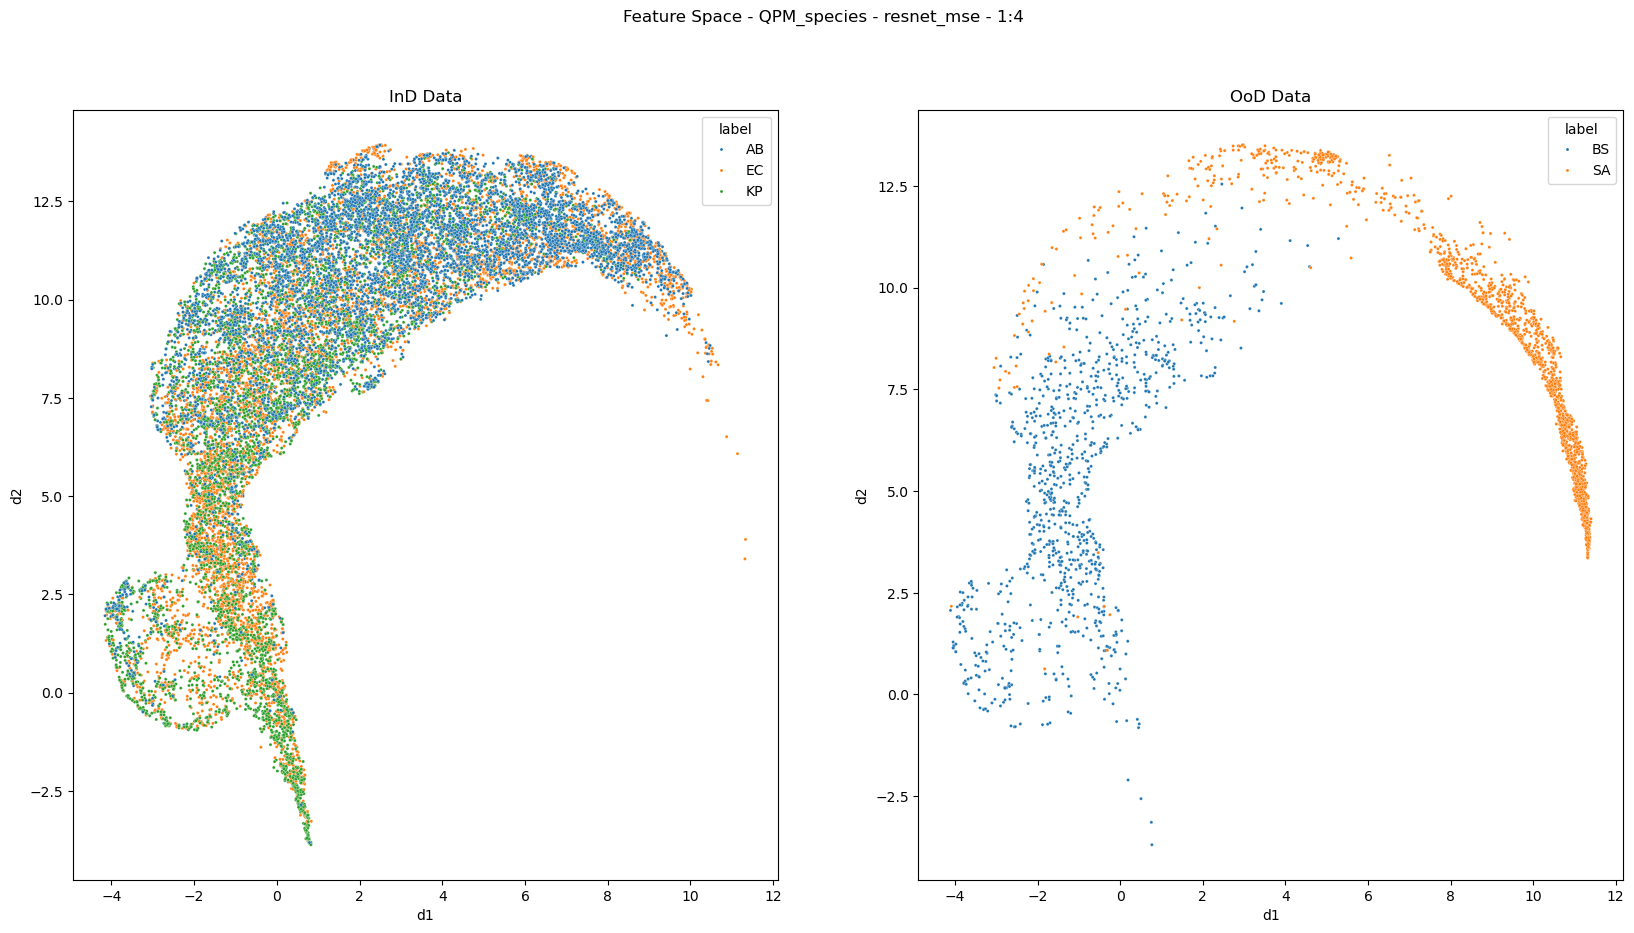

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

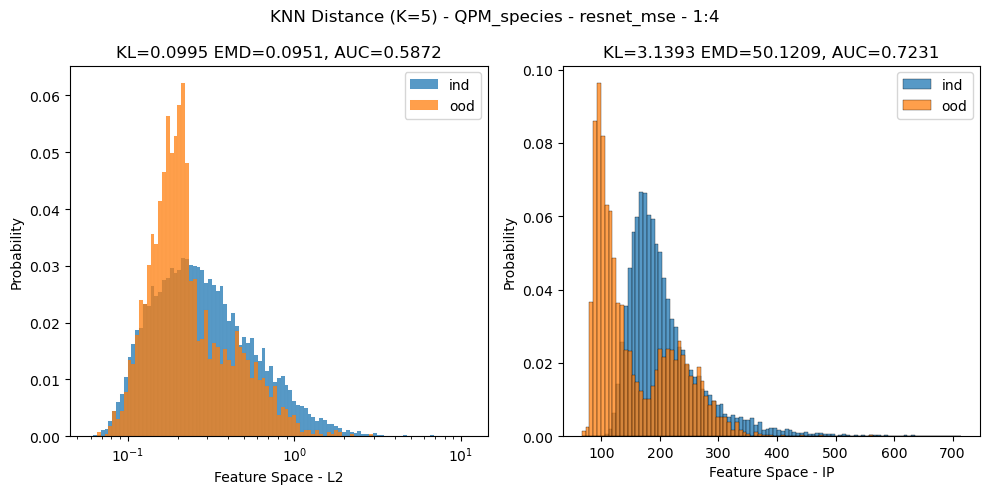

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

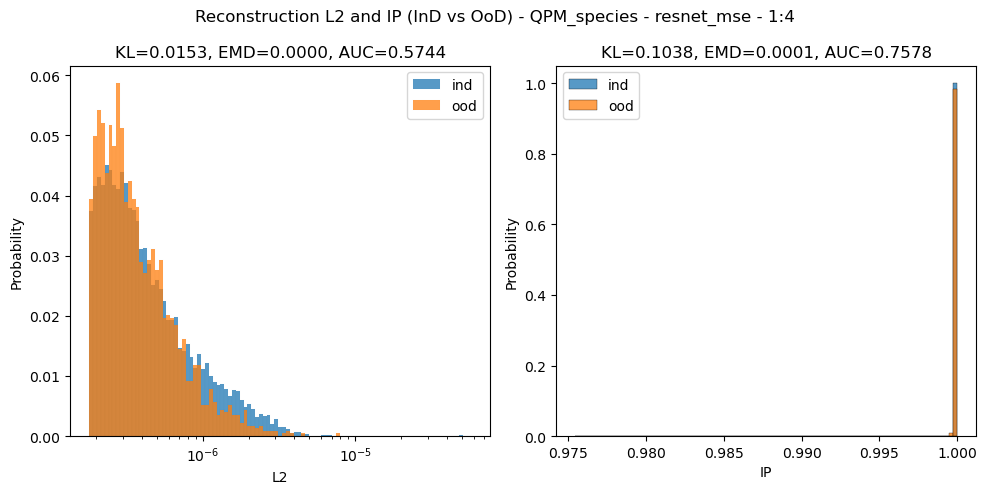

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)